In [1]:
import requests
import logging
import pandas as pd
from tqdm import tqdm
from typing import Tuple, List, Dict, Union, Optional
from requests.exceptions import RequestException
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.patches import Rectangle
import matplotlib.patheffects as path_effects

In [2]:
fe = fm.FontEntry(
    fname='/Users/davidegualano/Documents/Python FTBLData/SourceSansPro-Regular.ttf',
    name='SourceSansPro-Regular'
)
fm.fontManager.ttflist.insert(0, fe)
matplotlib.rcParams['font.family'] = fe.name

In [3]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

BASE_URL = "https://www.fotmob.com/api"


def get_league_fixtures(
    session: requests.Session, league_id: int, season: str
) -> Tuple[Optional[Dict], Optional[List[Dict]]]:
    """
    Fetch league details and matches from the Fotmob API.

    Args:
        session: The session instance to use for the request.
        league_id: ID of the league to fetch.
        season: The target season in the format 'YYYY/YYYY'.

    Returns:
        League details and matches data if successful, (None, None) otherwise.
    """
    league_url = f"{BASE_URL}/leagues"
    params = {"id": league_id, "season": season}

    try:
        response = session.get(league_url, params=params)
        response.raise_for_status()

        data = response.json()

        return data["details"], data["matches"]["allMatches"]
    except RequestException as e:
        logger.error(
            f"An error occurred while fetching data for league ID {league_id}: {e}"
        )
        return None, None


def extract_details(details: Dict) -> Dict[str, Union[str, int]]:
    """
    Extract key details from the league details data.

    Args:
        details: Raw league details data.

    Returns:
        Extracted details.
    """
    return {
        "country": details["country"],
        "name": details["name"],
        "selectedSeason": details["selectedSeason"],
        "type": details["type"],
    }


def extract_matches(matches: List[Dict]) -> List[Dict[str, Union[str, int, bool]]]:
    """
    Extract key details from matches data and structure it in a list of dictionaries.

    Args:
        matches: Raw matches data.

    Returns:
        A list of dictionaries with key match details.
    """
    return [
        {
            "game_id": match.get("id"),  # Extracting game ID
            "away_team": match.get("away", {}).get("name"),
            "home_team": match.get("home", {}).get("name"),
            "round": match.get("round"),
            "cancelled": match.get("status", {}).get("cancelled"),
            "finished": match.get("status", {}).get("finished"),
            "date": match.get("status", {}).get("utcTime"),
            "result": match.get("status", {}).get("scoreStr"),
        }
        for match in matches
    ]


def process_dataframe(df):
    """
    Process the DataFrame: Map country codes to full names, split the result column,
    and remove unnecessary columns.

    Args:
    - df (pd.DataFrame): The DataFrame containing the fetched league data.

    Returns:
    - pd.DataFrame: The processed DataFrame.
    """

    # Mapping country codes to full names
    country_map = {
        "ESP": "Spain",
        "ENG": "England",
        "GER": "Germany",
        "ITA": "Italy",
        "FRA": "France",
        "NED": "Netherlands",
        "INT": "International",
        "ARG": "Argentina",
        "BEL": "Belgium",
        "BRA": "Brazil",
        "POR": "Portugal",
        "RUS": "Russia",
        "SCO": "Scotland",
        "TUR": "Turkey",
        "USA": "United States",
    }
    df["country"] = df["country"].map(country_map)

    # Splitting result column into home and away scores
    df[["home_score", "away_score"]] = df["result"].str.split(" - ", expand=True)
    df.drop(columns=["result"], inplace=True)

    return df


def generate_date_hours() -> pd.DataFrame:
    """
    Generate a DataFrame with hourly timestamps between two dates.

    Returns:
        DataFrame with hourly timestamps.
    """
    date_hour_range = pd.date_range(start="2023-01-01", end="2024-12-31", freq="H")
    return pd.DataFrame({"date_hour": date_hour_range})

In [4]:
def main() -> pd.DataFrame:
    # Define leagues and target season
    leagues = [
        {"id": 87, "name": "laliga"},
        {"id": 47, "name": "premier-league"},
        {"id": 54, "name": "bundesliga"},
        {"id": 55, "name": "serie-a"},
        {"id": 53, "name": "ligue-1"},
        {"id": 57, "name": "eredivisie"},
        {"id": 42, "name": "champions-league"},
        {"id": 73, "name": "europa-league"},
        {"id": 112, "name": "liga-profesional"},
        {"id": 40, "name": "first-division-a"},
        {"id": 268, "name": "serie-a"},
        {"id": 48, "name": "championship"},
        {"id": 108, "name": "league-one"},
        {"id": 61, "name": "liga-portugal"},
        {"id": 63, "name": "premier-league"},
        {"id": 64, "name": "premiership"},
        {"id": 71, "name": "super-lig"},
        {"id": 130, "name": "mls"},
    ]

    season = "2023/2024"
    final_data = pd.DataFrame()

    with requests.Session() as session:
        for league in leagues:
            details, matches = get_league_fixtures(session, league["id"], season)

            if details and matches:
                details_dict = extract_details(details)
                matches_dict = extract_matches(matches)

                league_df = pd.DataFrame(matches_dict)
                league_df = league_df.assign(**details_dict)

                final_data = pd.concat([final_data, league_df], ignore_index=True)

    final_data = process_dataframe(final_data)

    return final_data

In [5]:
if __name__ == "__main__":
    matches_df = main()


In [6]:
schedule0 = matches_df[matches_df['country'].isin(["Italy", "International"])]
schedule0.selectedSeason.unique()

array(['2023/2024'], dtype=object)

In [7]:
schedule = schedule0[schedule0['selectedSeason'].isin(["2023/2024"])]
id = schedule.filter(items=["game_id", "name"])
id.rename(columns={'game_id': 'matchId'}, inplace=True)

In [8]:
# Define the function to scrape shot data for a given matchId
def scrape_shots(mi):
    try: 
        params = {'matchId': mi}
        response = requests.get('https://www.fotmob.com/api/matchDetails', params=params)
        data = response.json()
        shotmap = data['content']['shotmap']['shots']
        shots_df = pd.DataFrame(shotmap)
        shots_df['matchId'] = mi
        return shots_df
    except Exception as e:
        print("Data not able to be scraped for MatchID : ",mi)

# Read the CSV containing the team names according to their respective Fotmob teamId
df_teamNameId = pd.read_csv("teamsFOTMOB.csv")

In [9]:
df_teamNameId.rename(columns={'fotmob_id': 'teamId'}, inplace=True)

In [10]:
match_ids = schedule.game_id.unique()

In [11]:
 # Initialize an empty list to store individual DataFrames
all_shots_dfs = []

# Loop through each matchId, scrape the shots data, merge with team names, and append to the list
for fotmob_matchId in tqdm(match_ids, desc="Processing matches"):
    #print(fotmob_matchId)
    shots_df = scrape_shots(fotmob_matchId)
    if shots_df is not None:
        shots_df = shots_df.merge(df_teamNameId[['teamId', 'team_name']], on='teamId', how='left')
        
        # Append the DataFrame to the list
        all_shots_dfs.append(shots_df)

# Concatenate all DataFrames in the list into a single DataFrame
final_shots_df = pd.concat(all_shots_dfs, ignore_index=True)

Processing matches:  76%|███████▌  | 491/646 [09:48<26:17, 10.18s/it]

Data not able to be scraped for MatchID :  4384188


Processing matches: 100%|██████████| 646/646 [13:28<00:00,  1.25s/it]
/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_43617/1705779419.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_shots_df = pd.concat(all_shots_dfs, ignore_index=True)


In [12]:
final_shots_df.columns

Index(['id', 'eventType', 'teamId', 'playerId', 'playerName', 'x', 'y', 'min',
       'minAdded', 'isBlocked', 'isOnTarget', 'blockedX', 'blockedY',
       'goalCrossedY', 'goalCrossedZ', 'expectedGoals',
       'expectedGoalsOnTarget', 'shotType', 'situation', 'period', 'isOwnGoal',
       'onGoalShot', 'isSavedOffLine', 'firstName', 'lastName', 'fullName',
       'teamColor', 'matchId', 'team_name', 'isFromInsideBox', 'shortName'],
      dtype='object')

In [13]:
final_shots_df = final_shots_df.merge(id)

In [14]:
playerlist = final_shots_df['playerName'].unique().tolist()
cleaned_playerlist = [name for name in playerlist if pd.notna(name)]
cleaned_playerlist.sort()

In [15]:
from IPython.display import display, HTML

# Step 3: Generate the HTML dropdown
options_html = ''.join([f'<option value="{name}">{name}</option>' for name in cleaned_playerlist])

dropdown_html = f"""
<input list="players" id="dropdown" oninput="handleInput()" placeholder="Choose Someone">
<datalist id="players">
    {options_html}
</datalist>
<p id="output"></p>
<script>
function handleInput() {{
    var input = document.getElementById("dropdown").value;
    var output = document.getElementById("output");
    output.innerHTML = "Selected: " + input;
}}
</script>
"""

# Display the dropdown
display(HTML(dropdown_html))

In [16]:
df_shots0 = final_shots_df[final_shots_df["playerName"] == 'Victor Osimhen']

df_shots1 = df_shots0.filter(items=['id', 'eventType', 'teamId', 'playerName', 'isBlocked', 'isOnTarget', 'goalCrossedY', 'goalCrossedZ',
                                  'expectedGoals', 'expectedGoalsOnTarget', 'isOwnGoal', 'shotType', 'matchId', 'team_name', 'name'])

df_shots = df_shots1[df_shots1["isBlocked"] == False]

In [17]:
nrows = df_shots.shape[0]
for y in range(nrows):
    title = df_shots['playerName'].iloc[y]

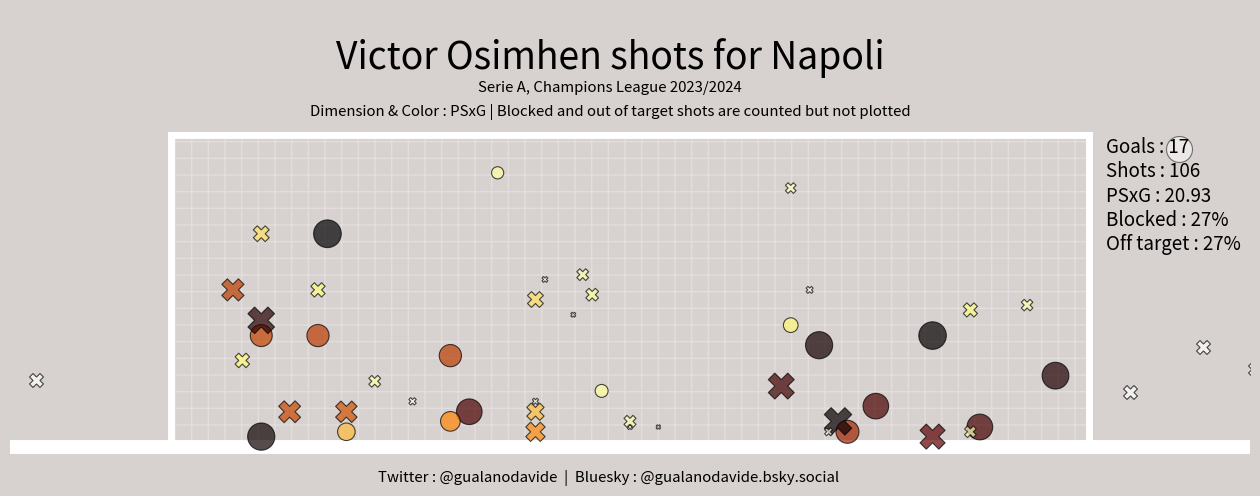

In [26]:
#Create figure
fig=plt.figure(facecolor='#D7D1CF')
fig.set_size_inches(16, 6)

#plt.gca().invert_xaxis()

# Goal post lines (shifted to the left by 1 unit)
plt.plot([27.4, 45], [0, 0], color='#FFFFFF', linewidth=10)
plt.plot([30.3, 37.7], [2.5, 2.5], color='#FFFFFF', linewidth=5)
plt.plot([37.7, 37.7], [0, 2.5], color='#FFFFFF', linewidth=5)
plt.plot([30.3, 30.3], [0, 2.5], color='#FFFFFF', linewidth=5)

# Goal net (shifted to the left by 1 unit)
plt.gca().add_patch(Rectangle((30.3, 0), 7.4, 2.5, fill=False, edgecolor='#FFFFFF', hatch='+', alpha=0.3))

#Tidy Axes
plt.axis('off')

goal_mask = (df_shots.eventType == 'Goal') & (df_shots.isOwnGoal == False) 
miss_mask = (df_shots.eventType == 'Miss') & (df_shots.isBlocked == False)
saved_mask = (df_shots.eventType == 'AttemptSaved') & (df_shots.isBlocked == False)
post_mask = df_shots.eventType == 'Post'

combined_xG = pd.concat([
    df_shots[goal_mask].expectedGoalsOnTarget,
    df_shots[saved_mask].expectedGoalsOnTarget,
    df_shots[post_mask].expectedGoalsOnTarget
])
norm = plt.Normalize(combined_xG.min(), combined_xG.max())
cmap0 = matplotlib.colormaps.get_cmap('afmhot_r')

sc1 = plt.scatter(68 - df_shots[goal_mask].goalCrossedY, df_shots[goal_mask].goalCrossedZ, marker='o', 
                  c=df_shots[goal_mask].expectedGoalsOnTarget, s=(400 * df_shots[goal_mask].expectedGoalsOnTarget), cmap=cmap0, norm=norm,
                  label='Goal', zorder=2, edgecolors='#000000', linewidths=0.8, alpha=0.7)

sc2 = plt.scatter(68 - df_shots[miss_mask].goalCrossedY, df_shots[miss_mask].goalCrossedZ, marker='X', c='#FFFFFF', s=100, label='Miss',
                  zorder=2, edgecolors='#000000', linewidths=0.8, alpha=0.7)
 
sc3 = plt.scatter(68 - df_shots[saved_mask].goalCrossedY, df_shots[saved_mask].goalCrossedZ, marker='X',
                  c=df_shots[saved_mask].expectedGoalsOnTarget, s=(400 * df_shots[saved_mask].expectedGoalsOnTarget), cmap=cmap0, norm=norm,
                  label='Saved', zorder=2, edgecolors='#000000', linewidths=0.8, alpha=0.7)

sc4 = plt.scatter(68 - df_shots[post_mask].goalCrossedY, df_shots[post_mask].goalCrossedZ, marker='X',
                  c=df_shots[post_mask].expectedGoalsOnTarget, s=(400 * df_shots[post_mask].expectedGoalsOnTarget), cmap=cmap0, norm=norm,
                  label='Post', zorder=2, edgecolors='#000000', linewidths=0.8, alpha=0.7)

sc5 = plt.scatter(38.425, 2.385, marker='o', c='#FFFFFF', s=350, zorder=0, edgecolors='#000000', linewidths=0.8, alpha=0.5)

fig.text(0.5, 0.8, f"{title} shots for {df_shots['team_name'].iloc[0]}", color='#000000', fontsize=30, va='center', ha='center')
fig.text(0.5, 0.75, f"{', '.join(df_shots['name'].unique())} { ', '.join(schedule['selectedSeason'].unique())}", color='#000000', fontsize=12, va='center', ha='center')
fig.text(0.5, 0.71, f"Dimension & Color : PSxG | Blocked and out of target shots are counted but not plotted", color='#000000', fontsize=12, va='center', ha='center')
fig.text(0.81, 0.57, f"Goals : {df_shots[goal_mask].expectedGoalsOnTarget.count()}\nShots : {len(df_shots1)}\nPSxG : {(df_shots.expectedGoalsOnTarget.sum()).round(2)}\nBlocked : {(((len(df_shots1) - len(df_shots))/len(df_shots1))*100):.0f}%\nOff target : {((len(df_shots[miss_mask].goalCrossedY)/len(df_shots1))*100):.0f}%", color='#000000', fontsize=15, va='center', ha='left')
fig.text(0.5, 0.1, f"Twitter : @gualanodavide  |  Bluesky : @gualanodavide.bsky.social ", color='#000000', fontsize=12, va='center', ha='center')

plt.ylim(ymin=-0.2, ymax=3.5)
plt.xlim(xmin=29, xmax=39)

plt.savefig(f'{title}PSxGmap.png', dpi=500, facecolor="#D7D1CF", bbox_inches="tight", transparent=True)


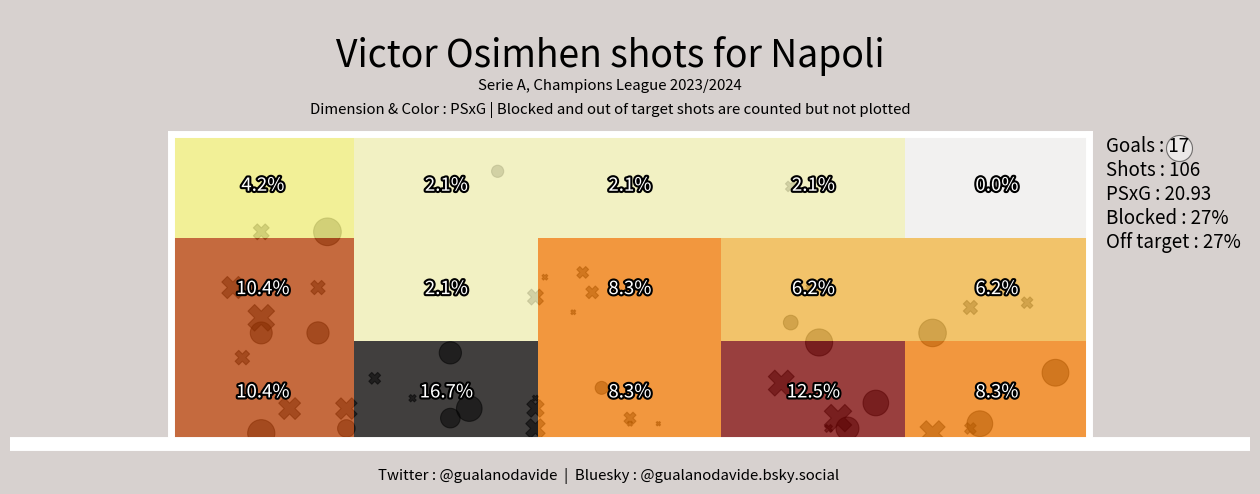

In [27]:
# Assuming df_shots is already defined and loaded

# Create figure
fig = plt.figure(facecolor='#D7D1CF')
fig.set_size_inches(16, 6)

# Goal post lines
plt.plot([27.4, 45], [0, 0], color='#FFFFFF', linewidth=10)
plt.plot([30.3, 37.7], [2.5, 2.5], color='#FFFFFF', linewidth=5)
plt.plot([37.7, 37.7], [0, 2.5], color='#FFFFFF', linewidth=5)
plt.plot([30.3, 30.3], [0, 2.5], color='#FFFFFF', linewidth=5)

# Tidy Axes
plt.axis('off')

# Define masks
goal_mask = (df_shots.eventType == 'Goal') & (df_shots.isOwnGoal == False) 
miss_mask = (df_shots.eventType == 'Miss') & (df_shots.isBlocked == False)
saved_mask = (df_shots.eventType == 'AttemptSaved') & (df_shots.isBlocked == False)
post_mask = df_shots.eventType == 'Post'

combined_xG = pd.concat([
    df_shots[goal_mask].expectedGoalsOnTarget,
    df_shots[saved_mask].expectedGoalsOnTarget,
    df_shots[post_mask].expectedGoalsOnTarget
])
norm = plt.Normalize(combined_xG.min(), combined_xG.max())
cmap0 = matplotlib.colormaps.get_cmap('afmhot_r')

# Scatter plots
sc1 = plt.scatter(68 - df_shots[goal_mask].goalCrossedY, df_shots[goal_mask].goalCrossedZ, marker='o', 
                  c='#000000', s=(400 * df_shots[goal_mask].expectedGoalsOnTarget),
                  label='Goal', zorder=0, edgecolors='#000000', linewidths=0.8, alpha=0.5)

sc3 = plt.scatter(68 - df_shots[saved_mask].goalCrossedY, df_shots[saved_mask].goalCrossedZ, marker='X',
                  c='#000000', s=(400 * df_shots[saved_mask].expectedGoalsOnTarget),
                  label='Saved', zorder=0, edgecolors='#000000', linewidths=0.8, alpha=0.5)

sc4 = plt.scatter(68 - df_shots[post_mask].goalCrossedY, df_shots[post_mask].goalCrossedZ, marker='X',
                  c='#000000', s=(400 * df_shots[post_mask].expectedGoalsOnTarget),
                  label='Post', zorder=0, edgecolors='#000000', linewidths=0.8, alpha=0.5)

sc5 = plt.scatter(38.425, 2.385, marker='o', c='#FFFFFF', s=350, zorder=0, edgecolors='#000000', linewidths=0.8, alpha=0.5)

# Filter data within the goal area
goal_area_mask = (68 - df_shots['goalCrossedY'] >= 30.3) & (68 - df_shots['goalCrossedY'] <= 37.7) & \
                 (df_shots['goalCrossedZ'] >= 0) & (df_shots['goalCrossedZ'] <= 2.5)
filtered_x = 68 - df_shots.loc[goal_area_mask, 'goalCrossedY']
filtered_y = df_shots.loc[goal_area_mask, 'goalCrossedZ']

# Create 2D histogram with bins of size 5 and 3
heatmap, xedges, yedges = np.histogram2d(filtered_x, filtered_y, bins=(5, 3), range=[[30.3, 37.7], [0, 2.5]])

# Calculate total number of shots inside the goal area
total_shots = np.sum(heatmap)

# Create x and y coordinates for bin centers
xpos, ypos = np.meshgrid(xedges[:-1] + (xedges[1] - xedges[0]) / 2, yedges[:-1] + (yedges[1] - yedges[0]) / 2, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()

# Plot heatmap
plt.imshow(heatmap.T, extent=[30.3, 37.7, 0, 2.5], origin='lower', cmap='afmhot_r', alpha=0.7, interpolation='sinc', zorder=1)

# Add annotations with percentages
for i in range(len(xpos)):
    count = heatmap.ravel()[i]
    percentage = (count / total_shots) * 100 if total_shots > 0 else 0
    text = plt.text(xpos[i], ypos[i], f'{percentage:.1f}%', color='#FFFFFF', ha='center', va='center', fontsize=15, zorder=2)
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='#000000'),
                                       path_effects.Normal()])

fig.text(0.5, 0.8, f"{title} shots for {df_shots['team_name'].iloc[0]}", color='#000000', fontsize=30, va='center', ha='center')
fig.text(0.5, 0.75, f"{', '.join(df_shots['name'].unique())} { ', '.join(schedule['selectedSeason'].unique())}", color='#000000', fontsize=12, va='center', ha='center')
fig.text(0.5, 0.71, f"Dimension & Color : PSxG | Blocked and out of target shots are counted but not plotted", color='#000000', fontsize=12, va='center', ha='center')
fig.text(0.81, 0.57, f"Goals : {df_shots[goal_mask].expectedGoalsOnTarget.count()}\nShots : {len(df_shots1)}\nPSxG : {(df_shots.expectedGoalsOnTarget.sum()).round(2)}\nBlocked : {(((len(df_shots1) - len(df_shots))/len(df_shots1))*100):.0f}%\nOff target : {((len(df_shots[miss_mask].goalCrossedY)/len(df_shots1))*100):.0f}%", color='#000000', fontsize=15, va='center', ha='left')
fig.text(0.5, 0.1, f"Twitter : @gualanodavide  |  Bluesky : @gualanodavide.bsky.social ", color='#000000', fontsize=12, va='center', ha='center')

plt.ylim(ymin=-0.2, ymax=3.5)
plt.xlim(xmin=29, xmax=39)

plt.savefig(f'{title}PSxGmapBins.png', dpi=500, facecolor="#D7D1CF", bbox_inches="tight", transparent=True)

